In [1]:
#Author: Evan Clark
#Github: https://github.com/evancosmos

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df = pd.read_csv("okcupid_profiles.csv")

# Intro

The following project uses Natural Languge Processing techniques like vectorizing and cosine simularity to change a dataset of dating profiles from OkCupid into comparible metrics.

Following that, a machine learning model known as Multi-layered Perceptron (a type neural network) uses this data to predict traits of individuals based on introductions.

# The Dataset

The following dataset has 22421 records after removing those with no written essays. Each essay in the dataset represents a self-written section of a user's dating profile. The features that will be found with it include age, sex, body_type, and offspring (desire/status for children). The outcome features can easy be modified in preprocessing below.

In [2]:
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [3]:
#Each essay section is responding to a particular prompt about themselves.
allEssays = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]

#Compound all essays into a single document
df[allEssays] = df[allEssays].fillna(value="")
df["compound"] = df[allEssays].agg('-'.join, axis=1)
df = df.drop(allEssays, axis=1)

#These are the outcome variables that will be predicted in this notebook, though additional computation time and imputation work could be done to find the rest.
outComeVars = ["age", "sex", "body_type", "drinks", "education", "offspring", "pets"] 

#Dropping NaN vars is fine since the dataset is so large, and most are filled anyway.
completeFeatures = df.dropna(subset="compound")
completeFeatures = completeFeatures.dropna(subset=outComeVars)

#Split up our features and outcome variables.
X = completeFeatures["compound"]
y = completeFeatures[outComeVars].copy()

#Change age into buckets rounded to the nearest 10
y["age"] = y["age"].apply(lambda x: round(x, -1))

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.1, random_state=0)

(15989,) (15989, 7)


In [4]:
y_train.head()

,age,sex,body_type,drinks,education,offspring,pets
4723,30,m,average,socially,graduated from college/university,"doesn't have kids, but might want them",likes dogs
40677,20,f,skinny,often,working on college/university,"doesn't have kids, but might want them",likes dogs and likes cats
23463,40,m,fit,socially,graduated from college/university,"doesn't have kids, but might want them",likes dogs and likes cats
6108,30,m,jacked,desperately,working on space camp,doesn't want kids,dislikes dogs and dislikes cats
55916,30,f,average,not at all,graduated from college/university,doesn't have kids,has dogs and likes cats


The following code snippet can be used if we need to transform catagorical values into numerical ones, I ended up not needing it at this time but wanted to keep it in case of future use.

# Vectorization

In [5]:
#We want to vectorize each of the essays so we can train models.

#Generate a corpus using all words in every essay of every user
corpusList = X_train.tolist()
corpus = ""
for i in corpusList:
    corpus += i

In [6]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
#Uncomment these packages if running for the first time
#nltk.download('stopwords')
#nltk.download('words')

#Get a list of each unique word in text data, removing punctuation and stop words
removePunc = string.punctuation
removePunc = removePunc.replace('-', '') #I want to keep hyphens

allwords = corpus.translate(str.maketrans('', '', removePunc))
allwords = word_tokenize(allwords)

#We need to remove as many unnessary words as possible to shrink the vocab and increase processing time.
stop_words = set(stopwords.words('english'))
vocab = [w for w in allwords if ((not w.lower() in stop_words) and (not w.isnumeric()))] #remove stopwords, numbers, and non-dictionary words
vocab = list(dict.fromkeys(vocab)) #Remove duplicates
dictionaryWords = set(words.words())
vocab = [w for w in vocab if (w in dictionaryWords)] #remove non dictionary words

In [7]:
#We can use a dictionary to know the index of a word in the TermMatrix
DictPerEssay = { vocab[i] : i for i in range(len(vocab)) }

#Example
DictPerEssay["school"]

1

In [8]:
#Init the term matrix, with each row representing the vector of words that appears in said row.
#e.g. TermMatrix[0] is the word vector for the first record.
def vectorize(corpusList):
    TermMatrix = [ [0]*len(vocab) for i in range(len(corpusList))]

    #For each record, if the current word is in vocab, increment termmatrix at coresponding spot
    for i in range(len(corpusList)):
        for word in corpusList[i].split():
            if word in DictPerEssay:
                TermMatrix[i][DictPerEssay[word]] += 1


    print("Term Matrix complete with " + str(len(TermMatrix)) + " records, each keeping track of " + str(len(TermMatrix[0])) + " words")
    return TermMatrix

TermMatrix = vectorize(corpusList)

Term Matrix complete with 9593 records, each keeping track of 21418 words


In [9]:
#Test to make sure our matrix is valid. Ignore double prints in the output, they don't affect our matrix.
cumValidVocab = 0
TestingEntryIndex = 0
index = 0

print(corpusList[TestingEntryIndex])
for i in corpusList[TestingEntryIndex].split():
    if i in DictPerEssay:
        print("Score of " + str(i) + " is " + str(TermMatrix[TestingEntryIndex][DictPerEssay[i]]))

i moved from tasmania (australia's alaska) to melbourne after high school to study for a few years, then onto cambodia for a couple more, back to australia, and now i'm here. i dig it.  random stuff:  - bars yes, the divier the better. i own the jukebox. - kinda been/there done that with the party scene. - i'd give myself a 7/10 for "being good with my hands" which by all accounts isn't particularly common in 2012. - i tend to enthusiastically pursue any activity with a decent propensity for injury. - i am prone to random adventures. recent trip to guatemala went from random idea to booked flights in about three hours. no hablo espanol.-fervently resisting the whole growing up/settling down thing. coming to grips with the fact that i'm approaching 28 and early-twenties-me would be shocked, appalled, and positively shit-scared by the amount of responsibility that somehow fell into my lap.  when i'm not doing or thinking about stuff like the above, i run corporate communications for a so

# Cosine Simularity Metric

The cosine simularity metric compares the distance, and therefor the simularity, of our now vectorized documents.

In [10]:
import math
#Cosine(x,y) = (x dot y)/((magnitude x)(magnitude y))

def cosine(x, y):
    numerator = 0
    xDenom = 0
    yDenom = 0
    for i in range(len(x)):
        numerator += (x[i] * y[i])
        xDenom += (x[i] ** 2)
        yDenom += (y[i] ** 2)
     
    if ((xDenom == 0) or (yDenom == 0)):
        return 0
    
    return (numerator/(math.sqrt(xDenom) * math.sqrt(yDenom)))

RecordIndexsToCompare = [0, 1, 2]

for RecordIndexToCompare in RecordIndexsToCompare:
    cosineScoreMatrix = [0]*len(TermMatrix)
    for x in range(len(TermMatrix)): #Compare our record of choice's essay vector to every other essay vector.
        if (x != RecordIndexToCompare):
            cosineScoreMatrix[x] = cosine(TermMatrix[RecordIndexToCompare], TermMatrix[x])
            
    print("\nThe most simular record to the " + str(RecordIndexToCompare) + " record is ")
    bestIndex = cosineScoreMatrix.index(max(cosineScoreMatrix))
    print(bestIndex)
    print("with a score of " + str(cosineScoreMatrix[bestIndex]))


The most simular record to the 0 record is 
8363
with a score of 0.3871522669803889

The most simular record to the 1 record is 
2879
with a score of 0.4496806423593277

The most simular record to the 2 record is 
2879
with a score of 0.5008139618772963


In [11]:
#Example of a record, followed by the record it has the highest cosine simularity with.
print(corpusList[RecordIndexToCompare])
print("\n")
print(corpusList[bestIndex])

update since i don't like to date around, i've changed my "looking for" to reflect that i'm not looking for dates. further reports as events warrant, i guess? i dunno, i'm still kinda open to meeting people for "new friends" and "activity partners". just know that i'm seeing someone, so there's no surprises.  6/27/12  i'm a tiny bit shy, so occasionally it takes a little effort to break the ice. but once you're in, you're in, and i'm all kinds of fun. and thankfully, i'm not the awkward brand of shy. i'm the cute kind.  i don't keep secrets, i'm pretty straightforward with my opinions, and i kinda wear my heart on my sleeve. i live by the golden rule, and i consider it a blessing and a curse to live with an abundance of empathy. i would drop everything for a friend in need.  also, my name is not bob. so there's that.-i moved to california about 6 years ago from the east coast, and it took me a few years to find the right group of people to really make me believe this was the place for 

In [12]:
#Features of record
y_train.iloc[RecordIndexToCompare]

age                                              40
sex                                               m
body_type                                       fit
drinks                                     socially
education         graduated from college/university
offspring    doesn't have kids, but might want them
pets                      likes dogs and likes cats
Name: 23463, dtype: object

In [13]:
#Features of record with highest cosine simularity to the above
y_train.iloc[bestIndex]

age                                     20
sex                                      m
body_type                           skinny
drinks                            socially
education    working on college/university
offspring                doesn't want kids
pets                            likes cats
Name: 18349, dtype: object

# Predicting Labels: Multi-layer Perceptron (Neural Network)

In [14]:
from sklearn.neural_network import MLPClassifier
from collections import Counter
xTestVectorized = vectorize(X_test.tolist())

def mlpPredictAndGraph(OutcomeToTest, goalline=False):
    mlp = MLPClassifier(random_state=0, max_iter=300).fit(TermMatrix, y_train[OutcomeToTest])
    mlpPredictions = mlp.predict(xTestVectorized)
    mlp.score(xTestVectorized, y_test[OutcomeToTest])
    
    print("Accuracy of MLP on test data is " + str(mlp.score(xTestVectorized, y_test[OutcomeToTest])))
    
    if (goalline):
        plt.scatter(mlpPredictions, y_test[OutcomeToTest], alpha=0.1)
        plt.plot([0, 60], [0, 60], c='red', linewidth=0.5) #Goal line
        
    else:
        #Scale dot size with occurance
        #https://stackoverflow.com/questions/46700733/how-to-have-scatter-points-become-larger-for-higher-density-using-matplotlib
        c = Counter(zip(mlpPredictions, y_test[OutcomeToTest]))
        s = [c[(xx,yy)] for xx,yy in zip(mlpPredictions, y_test[OutcomeToTest])] #occurance of each dot
        pltted = plt.scatter(mlpPredictions, y_test[OutcomeToTest], c=s, cmap="cool")
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('# of occurances', rotation=270)
        plt.xticks(rotation=90)
       
    plt.title("Predictions vs Actual using MLP")
    plt.xlabel("Predicted values for " + OutcomeToTest)
    plt.ylabel("Actual Values")
    
    plt.show()
    return mlp

Term Matrix complete with 1599 records, each keeping track of 21418 words


Accuracy of MLP on test data is 0.43839899937460913


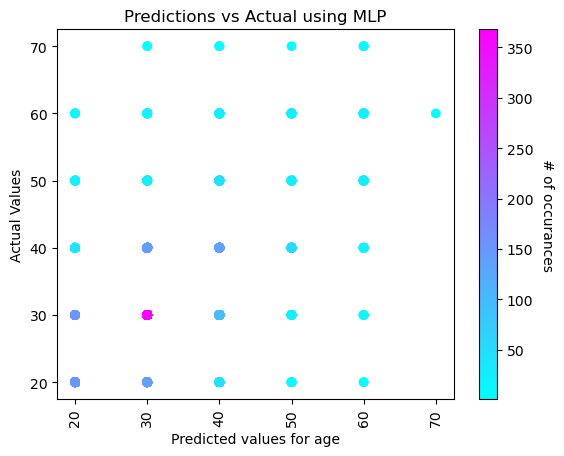

MLPClassifier(max_iter=300, random_state=0)

In [22]:
mlpPredictAndGraph("age")

Accuracy of MLP on test data is 0.6848030018761726


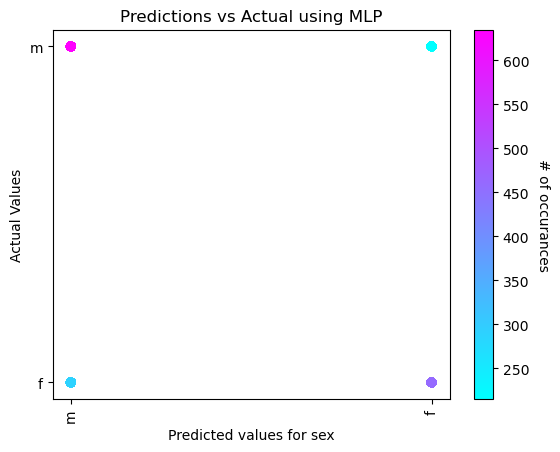

MLPClassifier(max_iter=300, random_state=0)

In [16]:
mlpPredictAndGraph("sex")

Accuracy of MLP on test data is 0.2395247029393371


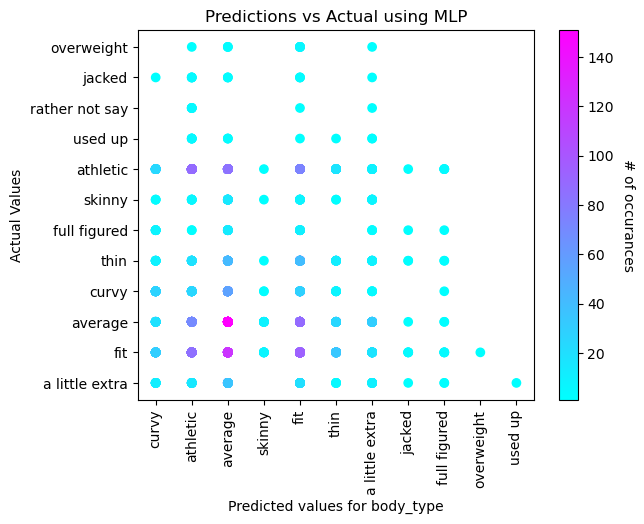

MLPClassifier(max_iter=300, random_state=0)

In [17]:
mlpPredictAndGraph("body_type")

Accuracy of MLP on test data is 0.2401500938086304


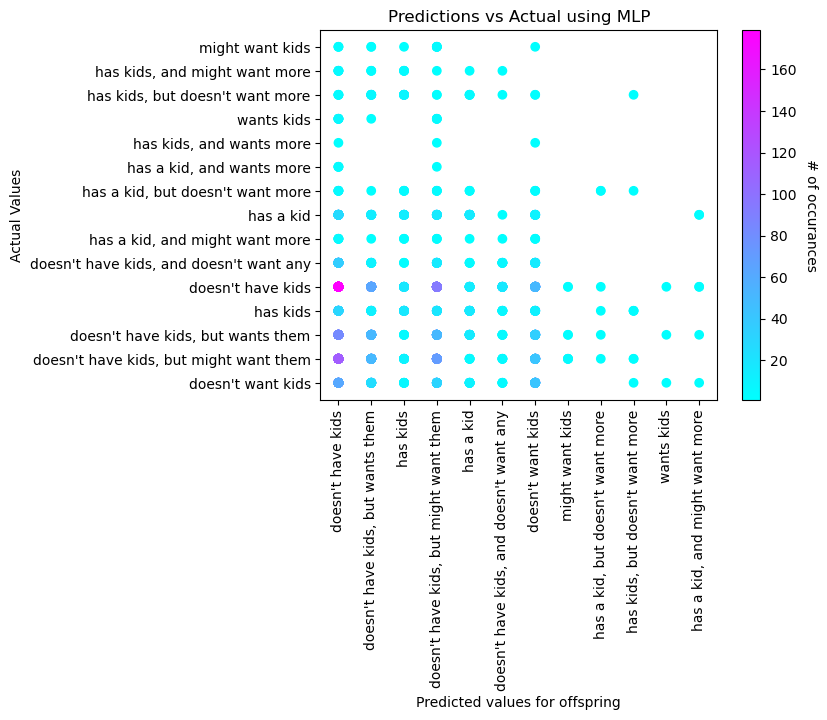

MLPClassifier(max_iter=300, random_state=0)

In [18]:
mlpPredictAndGraph("offspring")

Accuracy of MLP on test data is 0.624765478424015


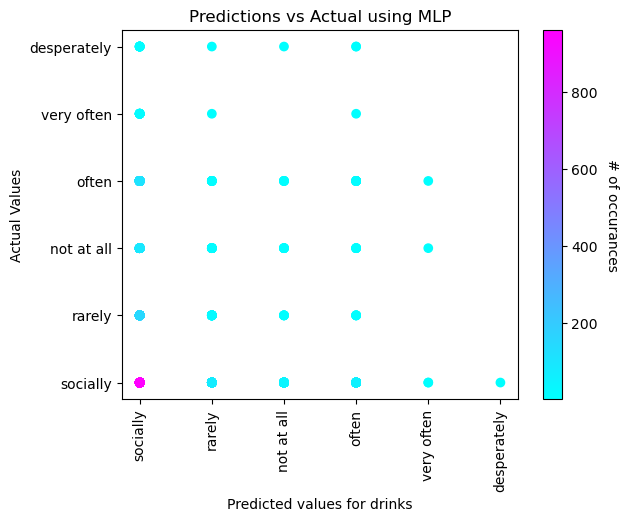

MLPClassifier(max_iter=300, random_state=0)

In [19]:
mlpPredictAndGraph("drinks")

Accuracy of MLP on test data is 0.35647279549718575


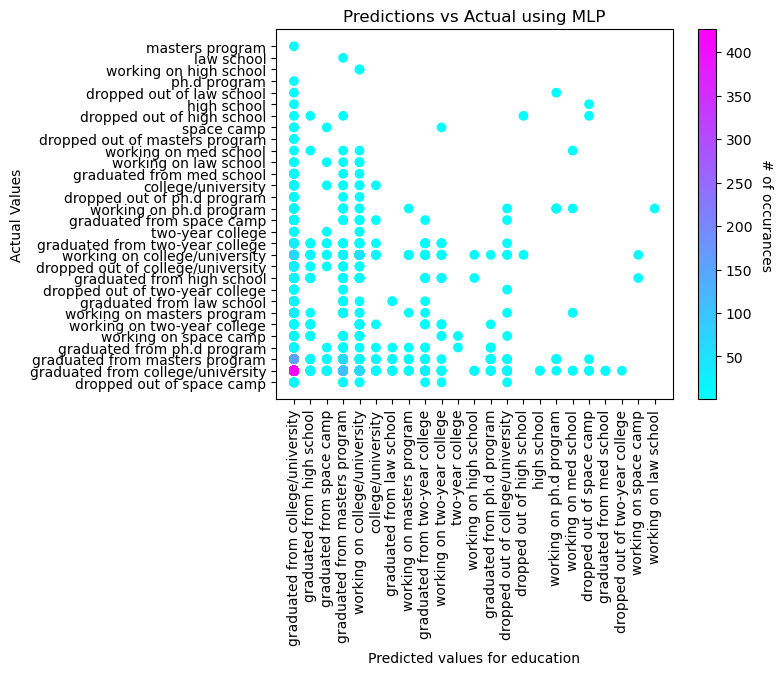

MLPClassifier(max_iter=300, random_state=0)

In [20]:
mlpPredictAndGraph("education")

Accuracy of MLP on test data is 0.275797373358349


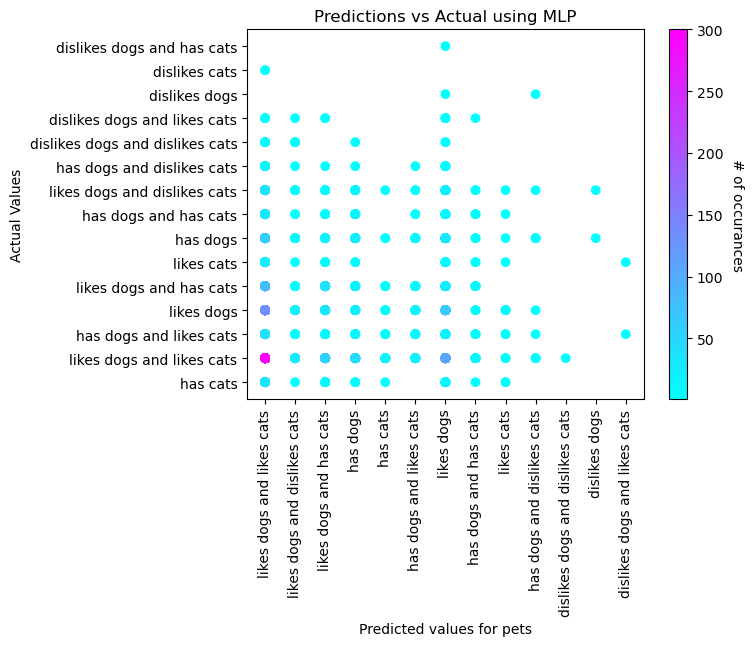

MLPClassifier(max_iter=300, random_state=0)

In [21]:
mlpPredictAndGraph("pets")